# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1], X_train.shape[2], X_train.shape[3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.bincount(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Examples of every traffic sign:


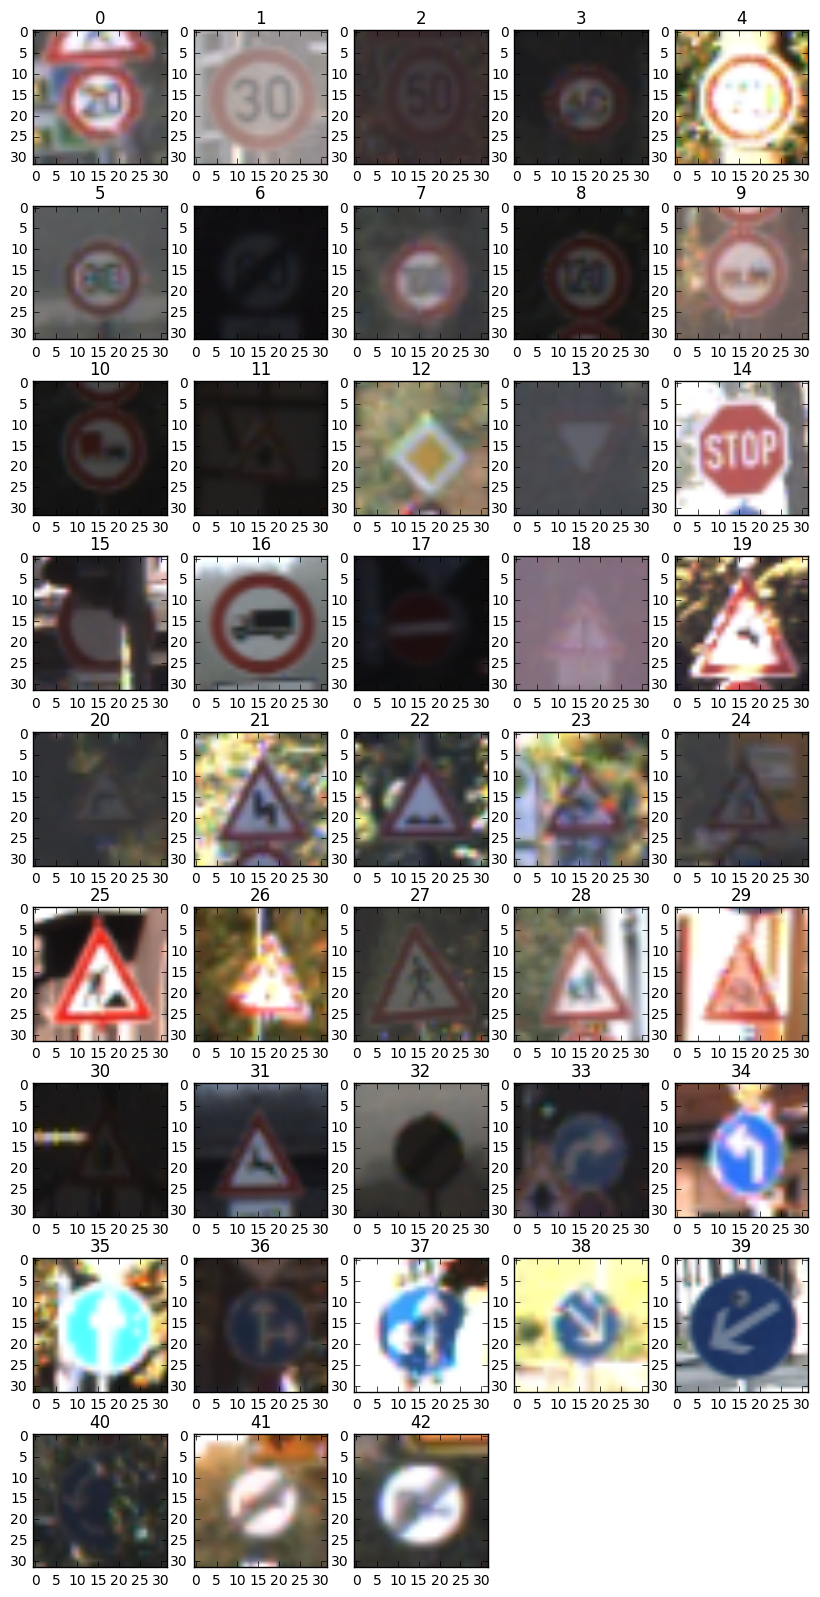

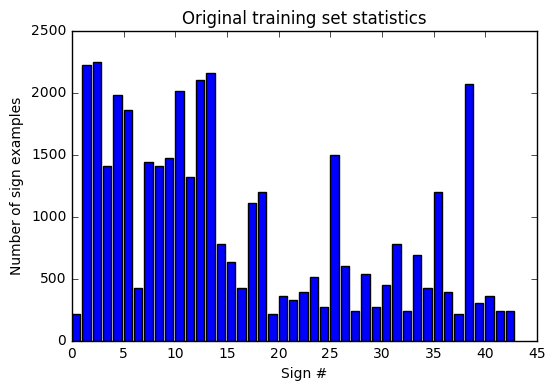

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import cv2

# Visualizations will be shown in the notebook.
%matplotlib inline

def plot_statistics(y, title):
    class_examples = np.bincount(y)
    classes = np.arange(class_examples.shape[0])
    plt.figure()
    plt.title(title)
    plt.xlabel('Sign #')
    plt.ylabel('Number of sign examples')
    plt.bar(classes, class_examples)
    plt.show()

# Plot a sign image of every class
def plot_every_class_image(x, y):
    assert(x.shape[0] == y.shape[0])
    images_shape = n_classes,
    images_shape += x.shape[1:]
    images = np.empty(images_shape, x.dtype)
    seen_numbers = set()
    idx = 0
    while len(seen_numbers) < n_classes and idx < x.shape[0]:
        if y[idx] not in seen_numbers:
            images[y[idx]] = x[idx]
            seen_numbers.add(y[idx])
        idx += 1
    plt.figure(figsize=(10., 20.))
    print('Examples of every traffic sign:')
    for idx in range(images.shape[0]):
        ax = plt.subplot(9, 5, idx+1)
        ax.set_title(idx)
        plt.imshow(images[idx])
    plt.show()

plot_every_class_image(X_train, y_train)
plot_statistics(y_train, 'Original training set statistics')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

A normalized example


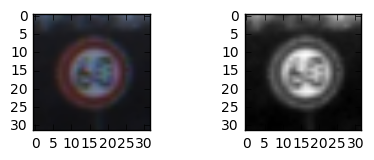

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Convert RGB images to YUV and normalize them
def normalize_image(img):
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    grey = grey[:,:,0]
    norm = np.zeros_like(grey)
    cv2.normalize(grey, norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    result = np.reshape(norm, (image_shape[0], image_shape[1], 1))
    return result

def normalize_set(x):
    x_shape = x.shape[0], x.shape[1], x.shape[2], 1
    new_x = np.empty(x_shape, x.dtype)
    for i in range(x.shape[0]):
        new_x[i] = normalize_image(x[i])
    return new_x

print('A normalized example')
orig_img = X_train[random.randint(0, len(X_train))].squeeze()
plt.figure(figsize=(5., 1.5))
plt.subplot(121)
plt.imshow(orig_img)
plt.subplot(122)
plt.imshow(cv2.cvtColor(normalize_image(orig_img), cv2.COLOR_GRAY2RGB))
plt.show()

X_train = normalize_set(X_train)
X_test = normalize_set(X_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

_Solution._ Pictures of the training and testing sets are converted from RGB to YUV colorspace. Only Y-channel is used for further normalization and training the neural network. The normalization is done around the mean value of each picture.

_Justification._ The luma channel seems to be enough for extracting all necessary features since there are no traffic signs differenciated by color only. Using the chroma channels actually reduces the testing accuracy. I noticed that many pictures in the training set have wrong white balance, which is a common problem of digital photography. It may explain why learned color features of the training set are not much helpful - and even misleading - when recognizing signs in the testing set.

_Other research results._ A global and local (CLAHE) histogram equalization have been tried to apply, however they distorted small and not contrast features so much, that even the validation accuracy significantly decresead.

/home/carnd/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


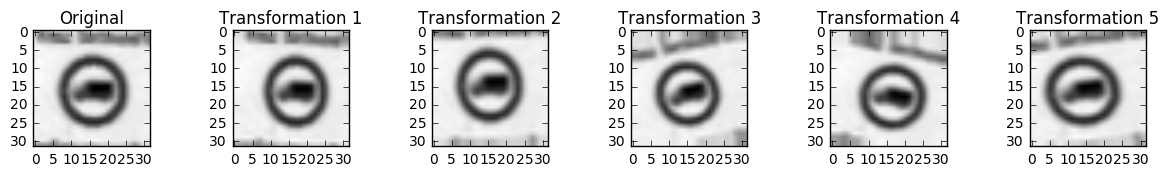

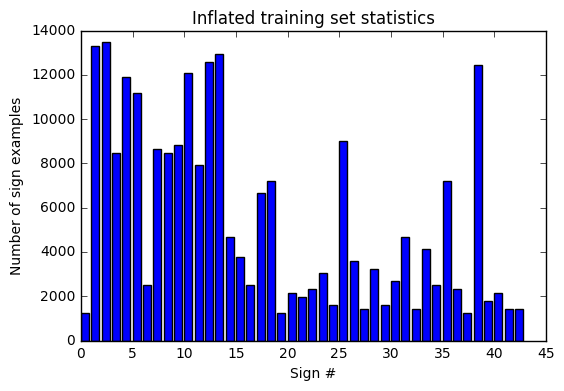

In [5]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from scipy import ndimage
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

N_TRANSFORMS = 5

def clip_func(out_coords, out_shape, in_shape):
    x = in_shape[0] / 2. - out_shape[0] / 2. + out_coords[0]
    y = in_shape[1] / 2. - out_shape[1] / 2. + out_coords[1]
    return x, y

def zoom_and_clip(img, fx, fy):
    zoomed_img = ndimage.zoom(img, zoom=(fy, fx), mode='nearest')
    result = ndimage.geometric_transform(zoomed_img,
                                         clip_func,
                                         output_shape=img.shape,
                                         mode='nearest',
                                         extra_arguments=(img.shape, zoomed_img.shape))
    return result

def get_random_transformation(img):
    ang = random.uniform(-15., 15.)
    shift_x = random.uniform(-2., 2.)
    shift_y = random.uniform(-2., 2.)
    scale_x = random.uniform(0.9, 1.1)
    scale_y = random.uniform(0.9, 1.1)
    result = ndimage.rotate(img.squeeze(), angle=ang, mode='nearest', reshape=False)
    result = ndimage.shift(result, shift=(shift_x, shift_y), mode='nearest')
    result = zoom_and_clip(result, scale_x, scale_y)
    result = np.reshape(result, (image_shape[0], image_shape[1], 1))
    return result

def inflate_training_set(x, y):
    transformed_x = []
    transformed_y = []

    # The progress bar is added for convenience since generating a jittered set of images
    # on the full training set may take about 7 minutes. If tqdm is not available, feel free
    # to remove the next line and replace the following for-loop with:
    #     for x_instance, y_instance in zip(x, y):
    instances_pbar = tqdm_notebook(range(y.shape[0]), unit=' instances')
    for instance, x_instance, y_instance in zip(instances_pbar, x, y):
        for i in range(N_TRANSFORMS):
            img = get_random_transformation(x_instance)
            transformed_x.append(img)
            transformed_y.append(y_instance)
    
    new_x = np.concatenate((x, transformed_x), axis=0)
    new_y = np.concatenate((y, transformed_y))

    return new_x, new_y

# Plot deformation examples
orig_img = X_train[random.randint(0, len(X_train))]
transformed_imgs = []
for i in range(N_TRANSFORMS):
    transformed_imgs.append(get_random_transformation(orig_img))
subp = 161
plt.figure(figsize=(15., 1.5))
ax = plt.subplot(subp)
ax.set_title('Original')
plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_GRAY2RGB))
for img in transformed_imgs:
    subp += 1
    ax = plt.subplot(subp)
    ax.set_title('Transformation %d' % (subp - 161))
    plt.imshow(cv2.cvtColor(img.squeeze(), cv2.COLOR_GRAY2RGB))
plt.show()

X_train, y_train = inflate_training_set(X_train, y_train)
X_train, y_train = shuffle(X_train, y_train)

plot_statistics(y_train, 'Inflated training set statistics')

In [6]:
### Split the training set into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print("New number of training examples: ", X_train.shape[0])
print("New number of validation examples: ", X_validation.shape[0])

New number of training examples:  188203
New number of validation examples:  47051


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

_Solution._ Firstly the original training set is inflated by generating five additional transformations of every picture. Each transformation of the original image is done by rotating it by -15..+15 degrees, then shifting it by -2..+2px and scaling it by 0.9..1.1 in each dimension. The values are randomly selected with a uniform distribution. Secondly the inflated training set is shuffled and split into a train (20% instances) and a validation (80% instances) sets.

_Justification._ The inflated training and validation sets, containing transformed copies of the original pictures, demonstrates a better testing accuracy beacuse of learning possible deformations of the sign pictures.

_Other research results._ The original training set statistics shows that number of trafic sign examples is not evenly distributed across the sign classes, e.g. there are less than 250 instances of sign "Speed limit 20km/h" and more than 2200 instances of sign "Speed limit 50km/h". I attempted equalizing the number of instances per class in the original training set before inflating it with transformed copies and splitting it into training and validation sets, i.e. I picked about 250 randomly selected instances of each sign class, discarding everything else. This approach resulted in a lees testing accuracy than using the full training set with an uneven distribution of examples. I think that's bacause the neural network could learn better the more frequent signs, while  having the same accuracy on infrequent signs. So it seems not beneficial to equalize class examples, but rather use all available data for training.

In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Constant definitions
MODEL_FILE_NAME = './model.ckpt'
EPOCHS = 20
BATCH_SIZE = 512
RATE = 1e-4
LAMBDA = 1e-4
SIGMA = 1e-2
MEAN = 0
KEEP_PROB = 0.5
LAYER_DEPTH = {
    'stage_1': 80,
    'stage_2': 160,
    'classifier': 100,
    'output': n_classes
}

tf.reset_default_graph()

weights = {
    'stage_1': tf.Variable(tf.truncated_normal(
        # 5x5 filters
        [5, 5, 1, LAYER_DEPTH['stage_1']],
        mean=MEAN,
        stddev=SIGMA), name='weights_1'),
    'stage_2': tf.Variable(tf.truncated_normal(
        # 5x5 filters
        [5, 5, LAYER_DEPTH['stage_1'], LAYER_DEPTH['stage_2']],
        mean=MEAN,
        stddev=SIGMA), name='weights_2'),
    'classifier': tf.Variable(tf.truncated_normal(
        [5*5*LAYER_DEPTH['stage_2']+7*7*LAYER_DEPTH['stage_1'], LAYER_DEPTH['classifier']],
        mean=MEAN,
        stddev=SIGMA), name='weights_3'),
    'output': tf.Variable(tf.truncated_normal(
        [LAYER_DEPTH['classifier'], LAYER_DEPTH['output']],
        mean=MEAN,
        stddev=SIGMA), name='weights_4')
}

biases = {
    'stage_1': tf.Variable(tf.zeros(LAYER_DEPTH['stage_1']), name='bias_1'),
    'stage_2': tf.Variable(tf.zeros(LAYER_DEPTH['stage_2']), name='bias_2'),
    'classifier': tf.Variable(tf.zeros(LAYER_DEPTH['classifier']), name='bias_3'),
    'output': tf.Variable(tf.zeros(LAYER_DEPTH['output']), name='bias_4')
}

def ConvNet(x, keep_prob):
    # Stage-1: convolutional, input 32x32x1, output 28x28x(stage-1-depth)
    s1 = tf.nn.conv2d(x, weights['stage_1'], strides=[1, 1, 1, 1], padding='VALID')
    s1 = tf.nn.bias_add(s1, biases['stage_1'])

    # Activation
    a1 = tf.nn.tanh(s1)
    
    # Stage-1 pooling: input 28x28x(stage-1-depth), output 14x14x(stage-1-depth)
    p1 = tf.nn.max_pool(a1,
                        ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1],
                        padding='VALID')

    # Additional stage-1 pooling to feed the classifier bypassing stage-2,
    # input 28x28x(stage-1-depth), output 7x7x(stage-1-depth)
    p1a = tf.nn.max_pool(a1,
                         ksize=[1, 4, 4, 1],
                         strides=[1, 4, 4, 1],
                         padding='VALID')
    
    # Stage-2: convolutional, input 14x14x(stage-1-depth), output 10x10x(stage-2-depth)
    s2 = tf.nn.conv2d(p1, weights['stage_2'], strides=[1, 1, 1, 1], padding='VALID')
    s2 = tf.nn.bias_add(s2, biases['stage_2'])
    
    # Activation
    a2 = tf.nn.tanh(s2)
    
    # Stage-2 pooling: input 10x10x(stage-2-depth), output 5x5x(stage-2-depth)
    p2 = tf.nn.max_pool(a2,
                        ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1],
                        padding='VALID')

    # Flatten: input 5x5x(stage-2-depth)
    p2 = flatten(p2)
    
    # Flatten: input 7x7x(stage-1-depth)
    p1a = flatten(p1a)

    # Concatenate: inputs from stage-1 and stage-2
    c = tf.concat(1, [p2, p1a])
    
    # Classifier: fully connected, output 100
    c = tf.add(tf.matmul(c, weights['classifier']), biases['classifier'])
    
    # Activation
    c = tf.nn.tanh(c)

    # Dropout
    c = tf.nn.dropout(c, keep_prob)

    # Output: fully connected, input 100, output (n_classes)
    logits = tf.add(tf.matmul(c, weights['output']), biases['output'])
    
    return logits

keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = ConvNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy) \
                 + LAMBDA * tf.nn.l2_loss(weights['stage_1']) \
                 + LAMBDA * tf.nn.l2_loss(weights['stage_2']) \
                 + LAMBDA * tf.nn.l2_loss(weights['classifier']) \
                 + LAMBDA * tf.nn.l2_loss(weights['output'])
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The chosen neural network architecture is inspired by the referred paper by Pierre Sermanet and Yann LeCun.  It's a multi-scale convolutional network with two convolution stages and a classifier containing a single fully-connected layer before the output layer:
* 1st stage: a convolutional layer of 80 features learned by 5x5 filters, followed by a tahn-activation and a 2x2 pooling resulting in the 14x14x80 output - this layer learns low-level features of images.
* 2nd stage: a convolutional layer of 160 features learned by 5x5 filters, followed by a tahn-activation and a 2x2 pooling resulting in the 5x5x160 output - this layer learns high-level features of images.
* Classifier: a fully connected layer of 100 neurons, taking a concatenation of inputs from 1st stage (aditionally pooled to size of 7x7x80) and 2nd stage (5x5x160), followed by a tahn-activation and a dropout enabled during training - this layer learns combinations of low-level and high-level features of images. 
* Output: a number of logits, one per traffic sign class.

There are additional detailed comments in the model definition above.

In [8]:
### Train your model here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        # The progress bar is added for convenience since an epoch may take a few
        # minutes depending on the hardware. If tqdm is not available, feel free
        # to remove the next line and replace the following for-loop with:
        #         for offset in range(0, num_examples, BATCH_SIZE):
        batches_pbar = tqdm_notebook(range(0, num_examples, BATCH_SIZE),
                                     desc='{:>2}/{}'.format(i+1, EPOCHS),
                                     unit='batch')
        for offset in batches_pbar:
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print('Epoch %d, Validation Accuracy = %.4f' % (i+1, validation_accuracy))

    saver = tf.train.Saver()
    saver.save(sess, MODEL_FILE_NAME)
    print("Model saved")

Training...

Epoch 1, Validation Accuracy = 0.7361

Epoch 2, Validation Accuracy = 0.9060

Epoch 3, Validation Accuracy = 0.9542

Epoch 4, Validation Accuracy = 0.9850

Epoch 5, Validation Accuracy = 0.9904

Epoch 6, Validation Accuracy = 0.9944

Epoch 7, Validation Accuracy = 0.9961

Epoch 8, Validation Accuracy = 0.9970

Epoch 9, Validation Accuracy = 0.9971

Epoch 10, Validation Accuracy = 0.9977

Epoch 11, Validation Accuracy = 0.9977

Epoch 12, Validation Accuracy = 0.9983

Epoch 13, Validation Accuracy = 0.9981

Epoch 14, Validation Accuracy = 0.9984

Epoch 15, Validation Accuracy = 0.9984

Epoch 16, Validation Accuracy = 0.9985

Epoch 17, Validation Accuracy = 0.9986

Epoch 18, Validation Accuracy = 0.9986

Epoch 19, Validation Accuracy = 0.9989

Epoch 20, Validation Accuracy = 0.9989
Model saved


In [9]:
### Testing the model
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, MODEL_FILE_NAME)
    print('Model loaded')
    test_accuracy = evaluate(X_test, y_test)
    print("Testing accuracy: %.4f" % (test_accuracy))

Model loaded
Testing accuracy: 0.9872


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

_Optimizer._ The model is trained using the **Adam** optimizer, which is pretty efficient with the default parameters. The only mandatory parameter - learning rate - is actually exponentionally decaying as learning progresses, which is another benefit  of the optimization algorithm. 

_BATCH._ The batch size of **512** is chosen as a tradeoff between the training performance and testing accuracy. 256 and 128 would converge after less epochs (due to more frequent back propagations), but they're more prone to overfitting and showing a lower testing accuracy. 1024 and higher would require too much computational power and/or training time. 

_EPOCHS._ The number of epochs **20** is enough for training the model with the rest of hyperparameters, without any overfitting.

_RATE._ The learning rate for the Adam optimizer is chosen **1e-4**. A learning rate of 1e-3 or may affect convergence, while a lower learning rate is not much improving accuracy, but increasing the training time due to a slower convergence.

_LAMBDA._ The regularization penalty on high weights is helping to generalize and preventing overfitting. The value of the regularization coefficient lambda is experimentally chosen  **1e-4**.

_KEEP_\__PROB._ Another regularization parameter is the probability of keeping a neuron of the classifier in dropout. The dropout is only applied when training. The keep probability of **0.5** appeared to generalize well, while any value in 0.4..0.6 seems to have  a similar effect on training. A much lower value would significantly increase the training time until convergence with not much improving generalization, while a value much higher than 0.6 would not have much effect on the test results.

_MEAN._ All weights are initialized with a random value picked from a normal distribution of mean **0**.

_SIGMA._ All weights are initialized with a random value picked from a truncated normal distribution of sigma **1e-2**.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I started with a LeNet-5 model as recommended and got an accuracy about 97% on the validation set, and about 88% on the testing set. Then I tried to implement the multi-scale architecture described in the referred paper on the same classification problem by Pierre Sermanet and Yann LeCun. With a reduced normalized data set of full-color pictures I got a validation set accuracy of 99.73%, testing set accuracy of 97.68% with some ballpark hyperparameters. The rest of my work was for tuning the multi-scale model.

_SS vs. MS architecture_. A traditional single-scale architecture with forwarding data layer-to-layer appeared to have a worse accuracy than a multi-scale network of the same architecture and hyperparameters, e.g. validation set accuracy 99.60% vs. 99.73%, testing set accuracy 97.01% vs. 97.68% for single-scale vs. multi-scale. It seems that the classifier benefits from getting low-level concepts from the 1st stage convolution as well as high-level concepts produced by the 2nd stage convolution, instead of relying on high-level features only.

_YUV vs. Y-only._ Using a single Y-channel of the full YUV-colorspace showed a better testing set accuracy with the same network architecture and hyperparameters, e.g. 97.68% vs. 98.08% for YUV vs Y-only. I think that color features are hard to rely on due to the differences in white balance of digital pictures of traffic signs.

_Network size._ I started with the default multi-scale network size 100-200-100, which stands for (Stage 1 depth)-(Stage 2 depth)-(classifier capacity), and tried to scale it down since the model seemed to overfit easily even with proper reqularization.
* An MS network of size 50-100-50 appeared to not learn enough features for a reliable recognition of unseen signs, e.g. the testing set accuracy was up to 98% upon convergence, with the hyperparameter values from the best 100-200-100 network.
* MS-50-100-100 had a better accuracy due to a higher capacity of the classifier, up to 98.5%, but couldn't grasp enough low- and hogh-level features.
* MS-80-160-80 had the best testing set accuracy of about 98.65%, but the reduced classifier capacity seemed to be not enough for an accurate classification.
* MS-80-160-100 reached the best testing accuracy of 98.8% and demonstrated a good generalization because of the reduced convolution depths - this is the chosen model.
* MS-100-200-100 reached the best testing accuracy of 99.15%, which is hard to reproduce though due to the random nature of the jittered training set. In most runs the testing accuracy is below 99%, not better than an MS-80-160-100.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

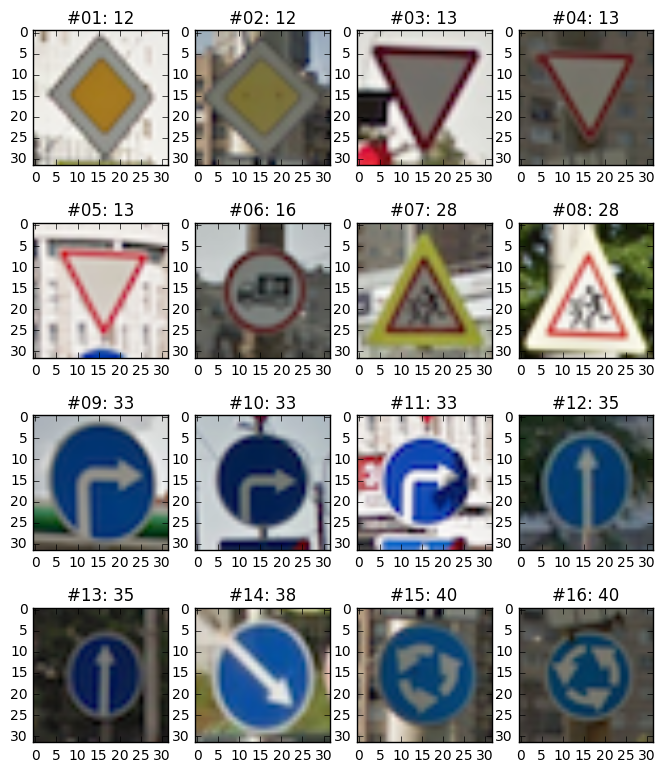

In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
testing_file = 'custom_test.p'
with open(testing_file, mode='rb') as f:
    custom = pickle.load(f)

X_custom, y_custom = custom['features'], custom['labels']
assert(X_custom.shape[0] == y_custom.shape[0])

plt.figure(figsize=(8., X_custom.shape[0] / 4 * 3.))
idx = 1
for x_cust, y_cust in zip(X_custom, y_custom):
    ax = plt.subplot(X_custom.shape[0]//4+1, 4, idx)
    ax.set_title('#%02d: %02d' % (idx, y_cust))
    plt.imshow(x_cust)
    idx += 1
plt.show()

X_custom = normalize_set(X_custom)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
All 16 pictures of traffic signs above were taken in the same district of St.Petersburg, Russia. There are a few challenges for the neural network trained on German traffic signs:
* Case #6: it's labeled as sign "Vehicles over 3.5 metric tons prohibited", but unlike the German sign with solid truck icon, the Russian truck icon contains a weight specification - "8T" in this case. This not fully valid test case was used to check how well the trained network generalizes on distortions.
* Case #7 and #8: fog and mist are frequent in St.Petersburg, so traffic signs "Children crossing" are made different from  European ones - there's a bright reflecting frame around each of them. The frame color is usually yellow, but the color may fade to white in the sun.
* Case #15: one can notice the roundabout sign is not just different from European ones, but it's different from case #16, located on the same street - it's the result of a poor national stadartization. Let's hee how well the network classifies it.

In [11]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, MODEL_FILE_NAME)
    print('Model loaded')
    sess = tf.get_default_session()
    predictions = sess.run(correct_prediction, feed_dict={x: X_custom, y: y_custom, keep_prob: 1.})
    print("Testing accuracy: %.3f" % (sum(predictions)/len(predictions)))
    for idx, prediction in zip(range(len(predictions)), predictions):
        result = 'correct'
        if prediction < 1:
            result = 'incorrect'
        print("#%02d - %s" % (idx+1, result))

Model loaded
Testing accuracy: 0.812
#01 - correct
#02 - correct
#03 - correct
#04 - correct
#05 - correct
#06 - incorrect
#07 - incorrect
#08 - correct
#09 - correct
#10 - correct
#11 - correct
#12 - correct
#13 - correct
#14 - correct
#15 - incorrect
#16 - correct


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
Even though the testing accuracy on captured pictures is 81.2%, which is way worse than on the testing set (98.72%), the trained model performs well on captured pictures of traffic signs, which are equivalent to the signs in the German data set:
* Test cases 1, 2, 3, 4, 5 are classified correctly because the signs have no differences with the German data set.
* Test cases 9, 10, 11, 12, 13, 14 and 16 are also classified correctly, despite of the different arrow styles: they are open in Germany and solid in Russia. Also arrows are located on different levels on images of test cases 10 and 11. It proves the network genralizes quite well.
* Test case 6 is misclassified, it's a new sign class never seen in the training set.
* Test case 7 is misclassified, but there's a bright reflecting frame aroung the signs, which has never been seen in the training set.
* Test case 15 is misclassified, but there's a weird arrow style and size never seen in the training set.

In [12]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
top5 = tf.nn.top_k(tf.nn.softmax(logits), 5)

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, MODEL_FILE_NAME)
    print('Model loaded')
    sess = tf.get_default_session()
    result = sess.run(top5, feed_dict={x: X_custom, keep_prob: 1.})
    predictions = sess.run(correct_prediction, feed_dict={x: X_custom, y: y_custom, keep_prob: 1.})
    test_case = 1
    print('Hypothesis and softmax probabilities:')
    for indices, values, prediction in zip(result.indices, result.values, predictions):
        place = 1
        for idx, val in zip(indices, values):
            if place == 1:
                result = 'correct'
                if prediction < 1:
                    result = 'incorrect'
                print("#%02d: %02d (%.1f%%, %s)" % (test_case, idx, val*100, result))
            else:
                print("     %02d (%.f%%)" % (idx, val*100))
            place += 1
        test_case += 1

Model loaded
Hypothesis and softmax probabilities:
#01: 12 (100.0%, correct)
     02 (0%)
     13 (0%)
     15 (0%)
     09 (0%)
#02: 12 (100.0%, correct)
     13 (0%)
     15 (0%)
     02 (0%)
     09 (0%)
#03: 13 (100.0%, correct)
     02 (0%)
     12 (0%)
     15 (0%)
     38 (0%)
#04: 13 (100.0%, correct)
     02 (0%)
     12 (0%)
     15 (0%)
     38 (0%)
#05: 13 (100.0%, correct)
     02 (0%)
     12 (0%)
     15 (0%)
     38 (0%)
#06: 09 (76.0%, incorrect)
     16 (12%)
     07 (4%)
     03 (2%)
     01 (1%)
#07: 29 (48.5%, incorrect)
     24 (24%)
     28 (16%)
     25 (4%)
     27 (1%)
#08: 28 (89.3%, correct)
     29 (6%)
     24 (2%)
     30 (1%)
     22 (0%)
#09: 33 (99.7%, correct)
     35 (0%)
     39 (0%)
     37 (0%)
     16 (0%)
#10: 33 (98.9%, correct)
     17 (0%)
     00 (0%)
     40 (0%)
     14 (0%)
#11: 33 (99.8%, correct)
     39 (0%)
     35 (0%)
     14 (0%)
     37 (0%)
#12: 35 (99.1%, correct)
     36 (0%)
     33 (0%)
     37 (0%)
     34 (0%)
#13: 35 (81.9

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
* The model is certain about test cases 1..5, 9..14 and 16 with the correct class probability of more than 90%.
* Test case 6 labeled "Vehicles over 3.5 metric tons prohibited" is misclassified as "No passing" sign, which has the same shape, but two car icons inside, shown from rear. The weight specification on the truck icon of the Russian variant of the sign my be recognized by the network as the gap between rear ends of the two cars on a "No passing" sign. The correct class is the 2nd choice though in the top-5 list.
* Test case 7 representing "Children crossing" signs is misclassified as "Bicycles crossing". These sign classes are same in shape, but different in intricate details, which might be missing in the low-resolution images. Perhaps many "Bicycles crossing" pictures in the training set have a bright background, which is falsely learned by the network as a feature, so the bright frames of Russian "Children crossing" signs might be recognized as the bright background. Another possible issue is a small number of training examples of the "Bicycle crossing" sign, which might lead to poorly learned features of the sign. The correct sign class is #3 in the top-5 list.
* Apparently the neural network is clueless about the weird roundabout sign in the test case 15, which is misclassified as "Vehicles over 3.5 metric tons prohibited". However the correct class is #2 in the top-5.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.